In [1]:
%load_ext autoreload

# Traces simulator v2

In [2]:
%autoreload
from tracer.simulator import TraceSimulator

sim = TraceSimulator(
    number_towers=50,
    number_users=500,
    number_cycles=24,
    expander=1,
    sigma=0.005,
    vel_friction=0.9,
#     method='distance_square',
#     verbose=True,
)

## Generate random user traces

In [3]:
sim.generate()

In [4]:
sim.traces.shape

(500, 24)

## Plot generated results

### Towers positions

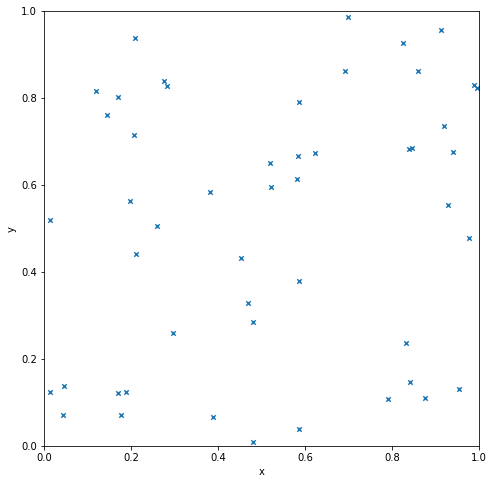

In [5]:
sim.towers_manager.plot_towers(annotate_towers=False);

### User trace

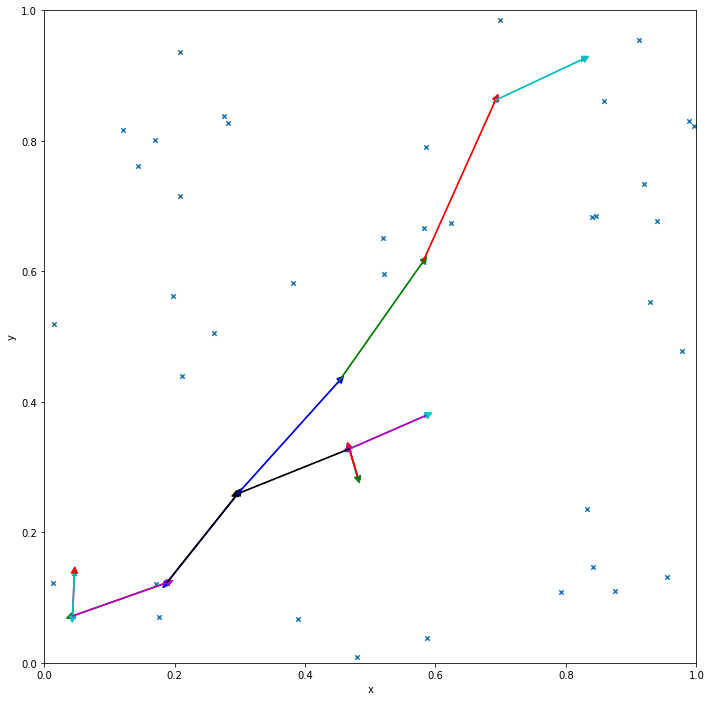

In [6]:
sim.towers_manager.plot_user_trace(sim.traces[0], annotate_towers=False)

In [7]:
sim.aggregated_data.shape

(24, 50)

# Trajectory recovery

In [8]:
%autoreload
import numpy as np
from tracer.recover import TrajectoryRecovery

tr = TrajectoryRecovery(
    number_users=500,
    towers=sim.towers,
    aggregated_data=sim.aggregated_data,
    vel_friction=0.9
)

In [9]:
tr.build_distribution_matrix()

In [10]:
tr.L.shape

(24, 500)

In [11]:
res = tr.trajectory_recovery_generator()

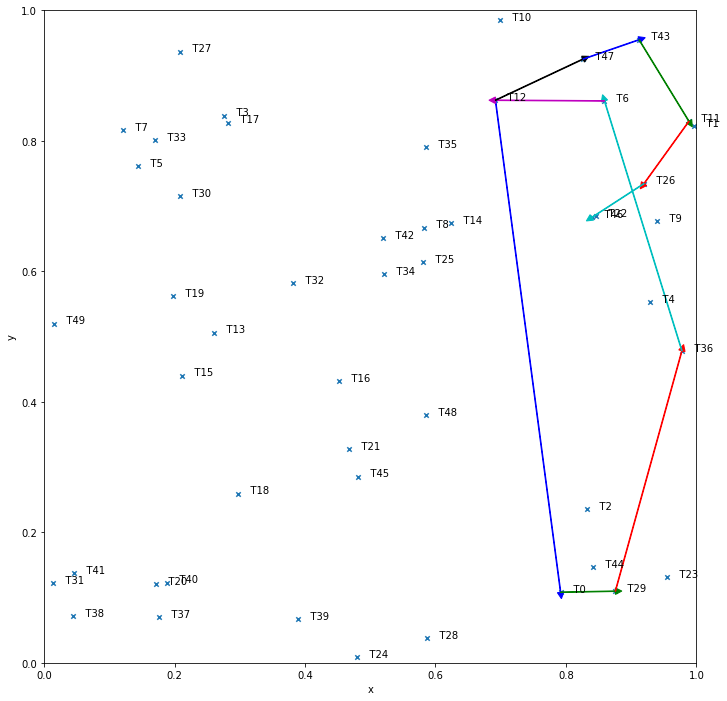

In [13]:
tr.towers_manager.plot_user_trace(res['recovered_trajectories'][:, 1])